In [48]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import datetime as dt
import numpy as np
from branca.colormap import linear

In [2]:
city = 'Luanda'

In [10]:
# read catchment AOI
cat = gpd.read_file('AOI/luanda_catchment_level4.shp').to_crs(epsg = 4326)
aoi = gpd.read_file('AOI/luanda.shp').to_crs(epsg = 4326)
centroid = cat.centroid

C:\Users\Owner\AppData\Local\Temp\ipykernel_17852\119210925.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = cat.centroid


In [4]:
output_folder = Path('output')

### Dams and reservoirs

In [5]:
dams = gpd.read_file(output_folder / f'{city.lower()}_dams.shp')
reservoirs = gpd.read_file(output_folder / f'{city.lower()}_reservoirs.shp')

In [6]:
dams['DAM_ID'] = dams['DAM_ID'].astype('int').astype('string')

In [9]:
# Create a folium map centered on the AOI
mymap = folium.Map(tiles="Cartodb Positron", control_scale = True)
bounds = cat.total_bounds.tolist()
mymap.fit_bounds([bounds[:2][::-1], bounds[2:][::-1]])

folium.GeoJson(
    cat,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'gray',
        'weight': 3
    },).add_to(mymap)

res_tooltip = folium.GeoJsonTooltip(fields=['RES_NAME'], aliases=['Reservoir Name'], localize=True, style=('background-color: white; color: #333333;'))
dam_tooltip = folium.GeoJsonTooltip(fields=['DAM_ID'], aliases=['Dam ID'], localize=True, style=('background-color: white; color: #333333;'))

# Add blue polygons for reservoirs
folium.GeoJson(
    reservoirs,
    style_function=lambda feature: {
        'fillColor': 'blue',
        'color': 'blue',
        'weight': 1,
    },
    highlight_function=lambda x: {"fillOpacity": 0.7},
    tooltip=res_tooltip,
    zoom_on_click=True
).add_to(mymap)

# Add CircleMarkers for dams
folium.GeoJson(
    dams,
    name="Dams",
    marker=folium.CircleMarker(radius=8, fill_color="brown", fill_opacity=0.4, color="brown", weight=1),
    tooltip = dam_tooltip,
    highlight_function=lambda x: {"fillOpacity": 0.7},
    zoom_on_click=True,
).add_to(mymap)

# Add legend manually
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 70px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 ">&nbsp; <b>Legend</b> <br>
                   &nbsp; Reservoirs &nbsp; 
                     <svg height="15" width="15">
                       <rect width="15" height="15" style="fill:blue;stroke:blue;stroke-width:2;fill-opacity:0.5" />
                     </svg><br>
                   &nbsp; Dams &nbsp; 
                     <svg height="10" width="10">
                       <circle cx="5" cy="5" r="5" style="fill:brown;stroke:brown;stroke-width:2;fill-opacity:0.5" />
                     </svg>
     </div>
     '''

mymap.get_root().html.add_child(folium.Element(legend_html))

mymap

### Precipitation

In [20]:
df = pd.read_csv(output_folder / 'precip.csv')
df['time'] = pd.to_datetime(df['time'])

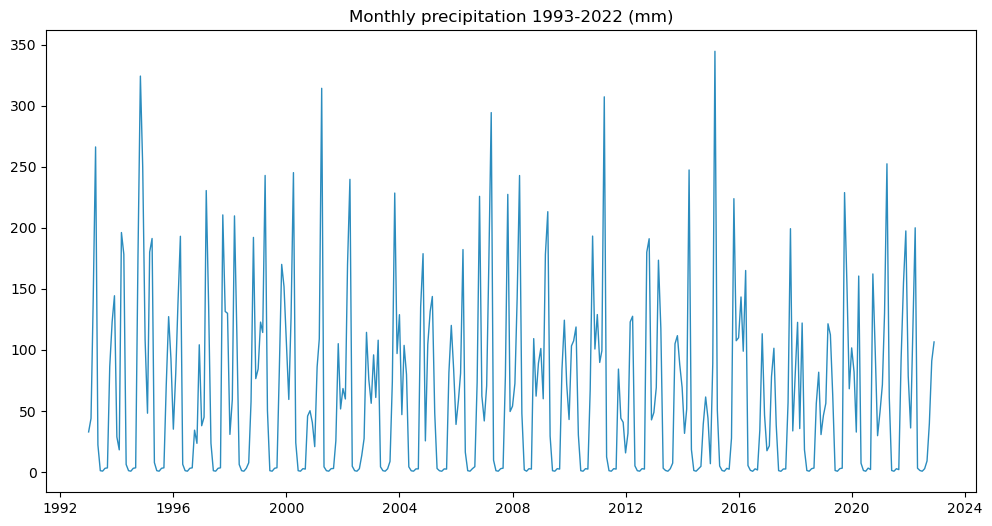

In [45]:
# plot

# Create the line chart using Seaborn with connected lines
plt.figure(figsize=(12, 6))

sns.lineplot(data=df, x='time', y='precip', linewidth=1, color = '#2b8cbe')
# sns.lineplot(data=df, x='time', y=df.precip.mean(), linewidth=1, color = 'grey')

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('Monthly precipitation 1993-2022 (mm)')

# plt.xticks(rotation=45)
plt.grid(False)
plt.show()

### Runoff

In [46]:
var_list = {'ncrun': 'Net cell runoff', 
            'qs': 'Fast surface and fast subsurface runoff'}
stat_list = {'mean': 'mean',
             'std': 'standard deviation'}
year_list = range(1987, 2017)

In [66]:
# Create a folium map centered on the AOI
mymap = folium.Map(tiles="Cartodb Positron", control_scale = True)
aoi_bounds = cat.total_bounds.tolist()
mymap.fit_bounds([aoi_bounds[:2][::-1], aoi_bounds[2:][::-1]])

folium.GeoJson(
    cat,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'gray',
        'weight': 3
    },
    control = False).add_to(mymap)

In [67]:
for var in var_list:
    # set colormap
    if var == 'ncrun':
        colormap = linear.GnBu_09.scale(json['raster_val'].min(), json['raster_val'].max())
        colormap.caption = f"{var_list[var]} (mean / standard deviation)"
        colormap.add_to(mymap)
    elif var == 'qs':
        colormap = linear.YlGnBu_09.scale(json['raster_val'].min(), json['raster_val'].max())
        colormap.caption = f"{var_list[var]} (mean / standard deviation)"
        colormap.add_to(mymap)
        
    for stat in stat_list:
        # read json
        json = gpd.read_file(output_folder / f'{city.lower()}_{var}_{stat}.geojson').to_crs('epsg:4326')
        
        # determine whether to show layer by default
        show = False
        if var == 'ncrun' and stat == 'mean':
            show = True
        
        # Add GeoJson layer with choropleth style
        folium.GeoJson(
            json,
            name = f'{var_list[var]} ({stat_list[stat]})',
            # overlay = False,
            style_function=lambda feature: {
                'fillColor': 'transparent' if pd.isna(feature['properties']['raster_val']) else colormap(feature['properties']['raster_val']),
                # 'fillColor': colormap(feature['properties']['raster_val']),
                'fillOpacity': 0.7,
                'weight': 0,
            },
            highlight_function=lambda x: {'fillOpacity': 0.9},
            tooltip=folium.GeoJsonTooltip(fields=['raster_val'], aliases = [f'{var_list[var]} ({stat_list[stat]})'], 
                                          labels=True, sticky=False),
            show = show
        ).add_to(mymap)

# Add Layer Control to toggle the choropleth layer
folium.LayerControl().add_to(mymap)

mymap

### Potential evapotranspiration

In [68]:
df = pd.read_csv(output_folder / 'potential_evaporation.csv')
df['time'] = pd.to_datetime(df['time'])

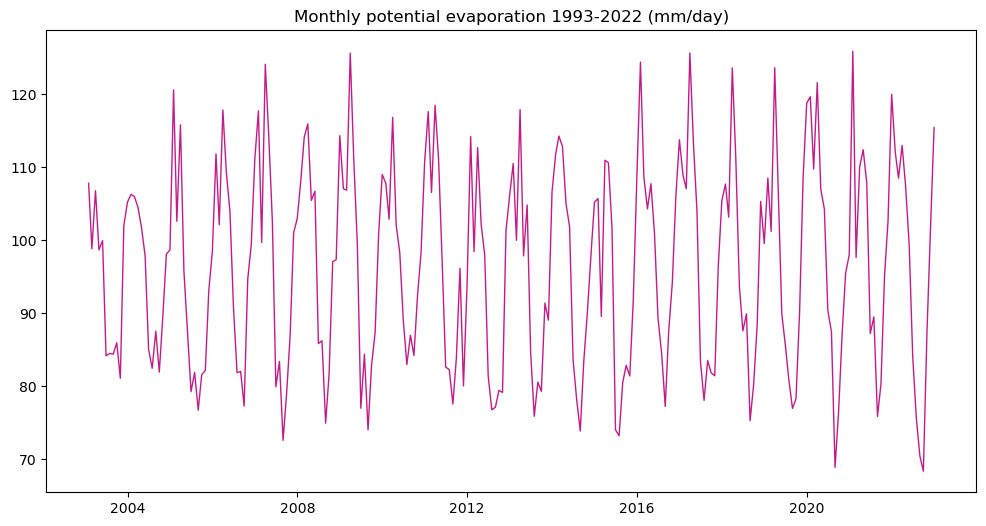

In [71]:
# plot

# Create the line chart using Seaborn with connected lines
plt.figure(figsize=(12, 6))

sns.lineplot(data=df, x='time', y='Ep', linewidth=1, color = '#c51b8a')

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('Monthly potential evaporation 1993-2022 (mm/day)')

# plt.xticks(rotation=45)
plt.grid(False)
plt.show()

### Water pollution

In [72]:
ec = pd.read_csv(output_folder / f'{city.lower()}_electrical_conductivity.csv')
noxn = pd.read_csv(output_folder / f'{city.lower()}_nitrate_nitrite.csv')
bod = pd.read_csv(output_folder / f'{city.lower()}_biological_oxygen_demand.csv')

In [73]:
ec['day'] = 1
ec['time'] = pd.to_datetime(ec[['year', 'month', 'day']])
noxn['day'] = 1
noxn['time'] = pd.to_datetime(noxn[['year', 'month', 'day']])
bod['day'] = 1
bod['time'] = pd.to_datetime(bod[['year', 'month', 'day']])

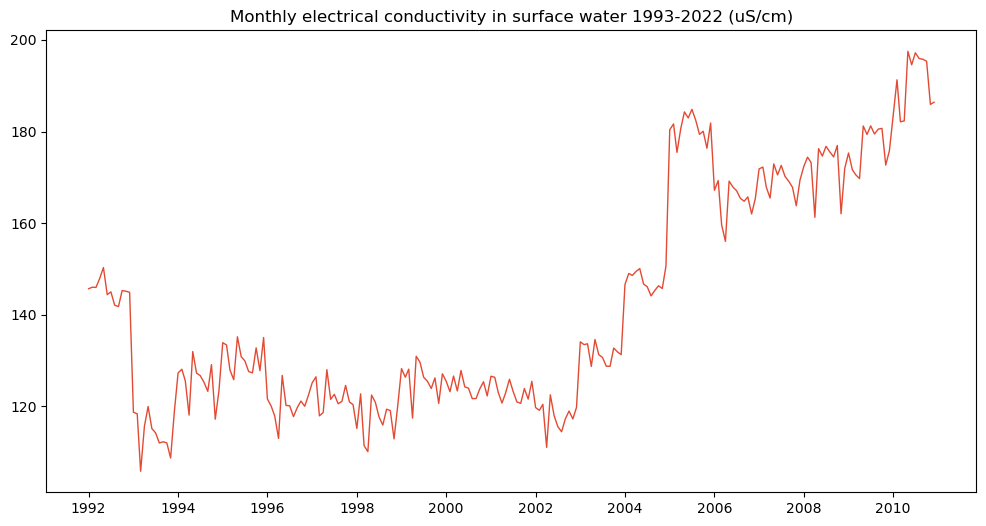

In [75]:
# plot

# Create the line chart using Seaborn with connected lines
plt.figure(figsize=(12, 6))

sns.lineplot(data=ec, x='time', y='preds', linewidth=1, color = '#e34a33')

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('Monthly electrical conductivity in surface water 1993-2022 (uS/cm)')

# plt.xticks(rotation=45)
plt.grid(False)
plt.show()

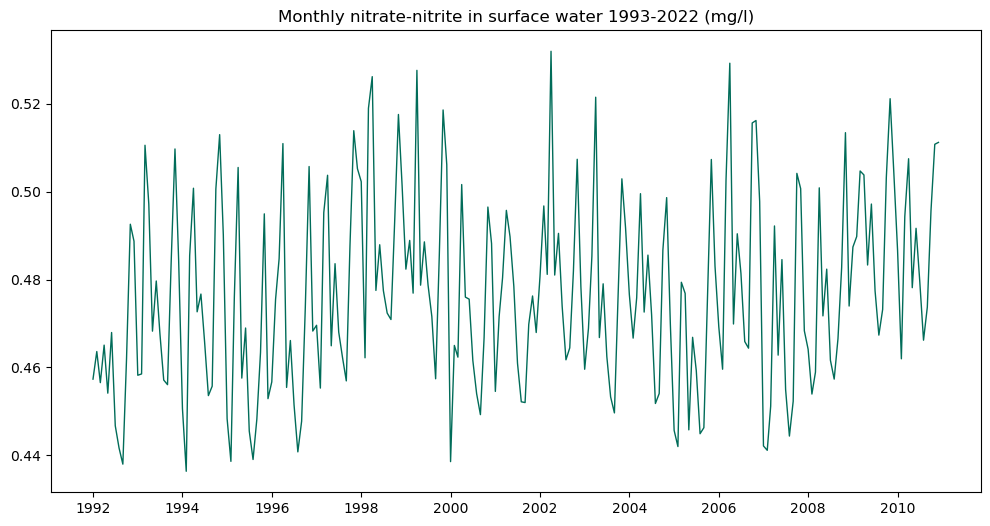

In [77]:
# plot

# Create the line chart using Seaborn with connected lines
plt.figure(figsize=(12, 6))

sns.lineplot(data=noxn, x='time', y='preds', linewidth=1, color = '#016c59')

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('Monthly nitrate-nitrite in surface water 1993-2022 (mg/l)')

# plt.xticks(rotation=45)
plt.grid(False)
plt.show()

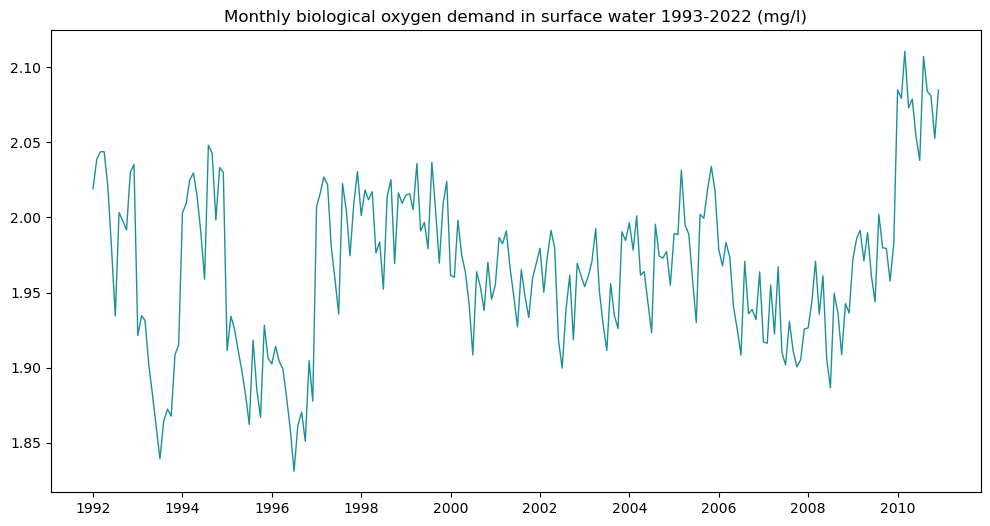

In [78]:
# plot

# Create the line chart using Seaborn with connected lines
plt.figure(figsize=(12, 6))

sns.lineplot(data=bod, x='time', y='preds', linewidth=1, color = '#1c9099')

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('Monthly biological oxygen demand in surface water 1993-2022 (mg/l)')

# plt.xticks(rotation=45)
plt.grid(False)
plt.show()

### Residential overlay with livestock

In [79]:
glw = gpd.read_file(output_folder / f'{city.lower()}_livestock.geojson').to_crs('epsg:4326')

In [84]:
# Create a folium map centered on the AOI
mymap = folium.Map(tiles="Cartodb Positron", control_scale = True)
aoi_bounds = aoi.total_bounds.tolist()
mymap.fit_bounds([aoi_bounds[:2][::-1], aoi_bounds[2:][::-1]])

folium.GeoJson(
    aoi,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'gray',
        'weight': 3
    },
    control = False).add_to(mymap)

**Could you please add the built-up area underlay to this map??**

In [85]:
# Create a colormap based on the 'YlOrRd' scale and the 'raster_val' column
colormap = linear.YlOrRd_09.scale(glw['raster_val'].min(), glw['raster_val'].max())
colormap.caption = "Number of livestocks"
colormap.add_to(mymap)

# Add GeoJson layer with choropleth style
folium.GeoJson(
    glw,
    name='Number of livestocks',
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['raster_val']),
        'fillOpacity': 0.7,
        'weight': 0,
    },
    highlight_function=lambda x: {'fillOpacity': 0.9},
    tooltip=folium.GeoJsonTooltip(fields=['raster_val'], aliases = ['Number of livestocks'], labels=True, sticky=False),
).add_to(mymap)

# Add Layer Control to toggle the choropleth layer
folium.LayerControl().add_to(mymap)

mymap